In [20]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
!pip install vit_keras
!pip install -U tensorflow-addons
from vit_keras import vit
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
TF version: 2.12.0
Hub version: 0.13.0
GPU is available


In [21]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 16 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4 with input size (299, 299)


In [22]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

In [23]:
IMAG_SIZE = 224 # All images will be resized to 224x224
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAG_SIZE, IMAG_SIZE))
  return  image, label

In [24]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)

In [25]:
do_fine_tuning = True #@param {type:"boolean"}

In [26]:
print("Building model with", MODULE_HANDLE)
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = metadata.features["label"].num_classes)

model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1072, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=metadata.features["label"].num_classes)
])
# model.build((None,)+IMAGE_SIZE+(3,))
# model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4


In [27]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [28]:
train = train.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat().shuffle(512)
validation = validation.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat()

In [29]:
steps_per_epoch = metadata.splits["train"].num_examples / BATCH_SIZE 
validation_steps = metadata.splits["validation"].num_examples / BATCH_SIZE
EPOCHS = 30
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

earlystopping = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(
    x=train,
    epochs=EPOCHS, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback, earlystopping],
    verbose=1).history

Epoch 1/30
63/63 [==============================] - 157s 1s/step - loss: 3.6944 - accuracy: 0.2109 - val_loss: 2.3884 - val_accuracy: 0.4307
Epoch 2/30
63/63 [==============================] - 58s 912ms/step - loss: 1.3484 - accuracy: 0.6660 - val_loss: 2.1809 - val_accuracy: 0.5117
Epoch 3/30
63/63 [==============================] - 70s 1s/step - loss: 1.3237 - accuracy: 0.6768 - val_loss: 1.3190 - val_accuracy: 0.6699
Epoch 4/30
63/63 [==============================] - 55s 860ms/step - loss: 0.6659 - accuracy: 0.8291 - val_loss: 1.4406 - val_accuracy: 0.6641
Epoch 5/30
63/63 [==============================] - 55s 874ms/step - loss: 0.4958 - accuracy: 0.8760 - val_loss: 1.7743 - val_accuracy: 0.6201
Epoch 6/30
63/63 [==============================] - 65s 1s/step - loss: 0.6390 - accuracy: 0.8379 - val_loss: 1.2187 - val_accuracy: 0.7158
Epoch 7/30
63/63 [==============================] - 62s 975ms/step - loss: 0.3870 - accuracy: 0.9111 - val_loss: 1.5717 - val_accuracy: 0.6807
Epoch 8

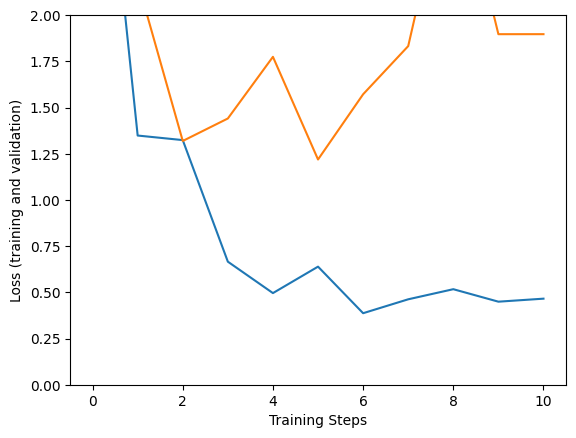

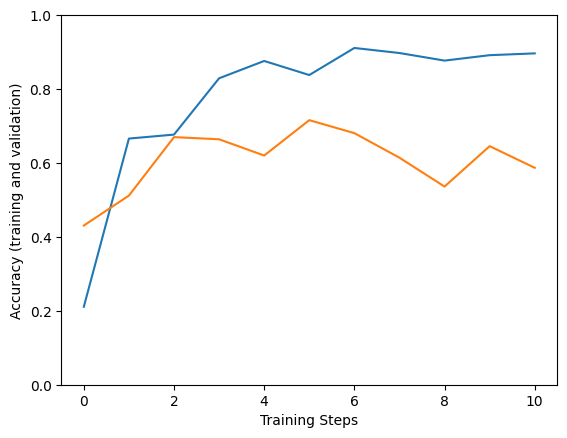

In [30]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [31]:
class_names = np.array(metadata.features['label'].names)
print(class_names)

['pink primrose' 'hard-leaved pocket orchid' 'canterbury bells'
 'sweet pea' 'english marigold' 'tiger lily' 'moon orchid'
 'bird of paradise' 'monkshood' 'globe thistle' 'snapdragon' "colt's foot"
 'king protea' 'spear thistle' 'yellow iris' 'globe-flower'
 'purple coneflower' 'peruvian lily' 'balloon flower'
 'giant white arum lily' 'fire lily' 'pincushion flower' 'fritillary'
 'red ginger' 'grape hyacinth' 'corn poppy' 'prince of wales feathers'
 'stemless gentian' 'artichoke' 'sweet william' 'carnation' 'garden phlox'
 'love in the mist' 'mexican aster' 'alpine sea holly'
 'ruby-lipped cattleya' 'cape flower' 'great masterwort' 'siam tulip'
 'lenten rose' 'barbeton daisy' 'daffodil' 'sword lily' 'poinsettia'
 'bolero deep blue' 'wallflower' 'marigold' 'buttercup' 'oxeye daisy'
 'common dandelion' 'petunia' 'wild pansy' 'primula' 'sunflower'
 'pelargonium' 'bishop of llandaff' 'gaura' 'geranium' 'orange dahlia'
 'pink-yellow dahlia?' 'cautleya spicata' 'japanese anemone'
 'black-eye

In [32]:
CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"]
output_class_names = np.array(CLASS_NAMES)

In [33]:
image_batch = []
label_batch = []
image_batch, label_batch = next(iter(test))

t = list(test.as_numpy_iterator())

for i in range(len(test)-1):
    image_batch = np.append(image_batch, t[i+1][0], axis=0)
    label_batch = np.append(label_batch, t[i+1][1], axis=0)


image_batch = image_batch
label_batch = label_batch

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

193/193 [==============================] - 82s 404ms/step
['barbeton daisy' 'king protea' 'sword lily' ... 'osteospermum'
 'passion flower' 'bird of paradise']


In [34]:
predicted_output_class_names = output_class_names[predicted_ids]
print(predicted_output_class_names)

['barbeton daisy' 'king protea' 'sword lily' ... 'osteospermum'
 'passion flower' 'bird of paradise']


In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = predicted_ids#np.argmax(probs, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = label_batch#np.argmax(y_test, axis=1)

# Obter os nomes das classes
# class_names = list(validgen.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
# confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# # Plotar a matriz de confusão usando seaborn
# sns.set()
# sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',)
# plt.xlabel('Previsão')
# plt.ylabel('Real')
# plt.title('Matriz de Confusão')
# plt.show()


Precisão: 0.5395999349487721


In [36]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Calcular a precisão, recall e F1-score para cada classe
report = classification_report(true_classes, predicted_classes, target_names=class_names)

# Exibir o relatório de classificação
print(report)

                           precision    recall  f1-score   support

            pink primrose       1.00      0.45      0.62        20
hard-leaved pocket orchid       0.97      0.78      0.86        40
         canterbury bells       0.07      0.45      0.12        20
                sweet pea       0.17      0.33      0.23        36
         english marigold       1.00      0.02      0.04        45
               tiger lily       0.00      0.00      0.00        25
              moon orchid       0.39      0.60      0.47        20
         bird of paradise       0.98      0.77      0.86        65
                monkshood       0.57      0.62      0.59        26
            globe thistle       0.83      0.96      0.89        25
               snapdragon       0.55      0.16      0.25        67
              colt's foot       0.92      0.52      0.67        67
              king protea       0.47      1.00      0.64        29
            spear thistle       0.90      0.93      0.91     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
